In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [3]:
total = pd.read_csv('C:/ML/dataset/supplygas/supply.csv', encoding='cp949')

# 1. 데이터 전처리

- 목적 : Dataframe 구성
- 과정 : feature들의 column 생성 및 feature 선택
- 개성 사항 : 히트맵을 활용한 coeff. 계산 및 feature 선택

In [4]:
total['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [5]:
d_map = {}

#d_map 딕셔너리를 생성해, 구분 encoding!      ex) A -> 0, B -> 1, ...
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

In [6]:
total['연월일'] = pd.to_datetime(total['연월일'])

In [20]:
total.head()

,연월일,시간,구분,공급량,year,month,day,weekday
0,2013-01-01,1,0,2497.129,2013,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1


In [7]:
'''
feauture들을 column으로 구성시켜 Dataframe 구성
=> dt.year, dt.month 등의 메소드를 활용해 새로운 column 생성
'''
total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

In [8]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

In [9]:
train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

C:\Users\User\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44553 missing from current

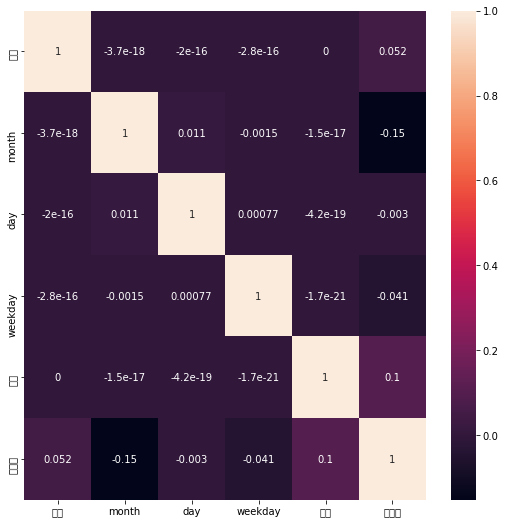

In [10]:
#Heatmap을 통해 coefficient 확인 => feature selection
import seaborn as sn

feature = ['구분', 'month', 'day', 'weekday', '시간', '공급량']
train_co = train[feature]

train_co.corr()

plt.figure(figsize=(9,9))
sn.heatmap(train_co.corr(), annot=True)

한글은 깨진 상태로 그래프에 표기됨. x축 features : (왼쪽부터) 구성, month, day, weekday, 시간, 공급량  y축 features : (아래부터) 공급량, 시간, weekday, day, month, 구성

coefficient 절대값이 크면 클수록, 공급량과의 상관 관계가 큰 것을 확인할 수 있음.

큰 순서대로 정렬 : month, 시간, 구성, weekday, day

## feature selection

5개의 feature들 모두 사용하기보단, coefficient 큰 것들만 선택하여 학습시키는 것이 더 효과적으로 학습할 것을 기대.

연관 계수가 0.15, 0.1인 *month*와 *day*를 feature로 선택!

In [12]:
features = ['month', '시간']
train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']

# 2. 학습

- 목적 : 모델 학습
- 과정 : 성능이 좋은 모델 학습
- 개선 요지 : lgb, xgb, ngb 등 다양한 모델 학습 및 앙상블 적용 가능

In [13]:
d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=10)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 2
[LightGBM] [Info] Start training from score 934.864036
Training until validation scores don't improve for 10 rounds
[20]	valid_0's l1: 603.319
[40]	valid_0's l1: 595.147
[60]	valid_0's l1: 594.237
[80]	valid_0's l1: 594.073
[100]	valid_0's l1: 594.02
[120]	valid_0's l1: 594.003
[140]	valid_0's l1: 593.992
[160]	valid_0's l1: 593.989
[180]	valid_0's l1: 593.987
Early stopping, best iteration is:
[188]	valid_0's l1: 593.986


# 3. 제출

In [14]:
test = pd.read_csv('C:/ML/dataset/supplygas/test.csv')
submission = pd.read_csv('C:/ML/dataset/supplygas/sample_submission.csv')

In [27]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [28]:
test['구분'] = test['구분'].map(d_map)

In [29]:
test.head()

,일자|시간|구분,일자,시간,구분,month
0,2019-01-01 01 A,2019-01-01,1,0,1
1,2019-01-01 02 A,2019-01-01,2,0,1
2,2019-01-01 03 A,2019-01-01,3,0,1
3,2019-01-01 04 A,2019-01-01,4,0,1
4,2019-01-01 05 A,2019-01-01,5,0,1


In [30]:
test['일자'] = pd.to_datetime(test['일자'])

In [31]:
test['month'] = test['일자'].dt.month

In [32]:
test.head()

,일자|시간|구분,일자,시간,구분,month
0,2019-01-01 01 A,2019-01-01,1,0,1
1,2019-01-01 02 A,2019-01-01,2,0,1
2,2019-01-01 03 A,2019-01-01,3,0,1
3,2019-01-01 04 A,2019-01-01,4,0,1
4,2019-01-01 05 A,2019-01-01,5,0,1


In [33]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [34]:
test_x = test[features]

In [35]:
preds = model.predict(test_x)

In [36]:
submission['공급량'] = preds

In [37]:
submission.to_csv('C:/ML/dataset/supplygas/baseline.csv', index=False)